# This notebook

In this notebook, we exlore the co-occurrence of keywords across a set of temporal subsets to detect patterns of change in co-occurrence.

Temporal subsets are defined according to key events in the timeline of covid19 pandemic in the UK:

- up to 23 March 2020 (excluded): pre-lockdown
- 23 March to 10 May 2020: strict lockdown
- 11 May 2020 onwards: post- strict lockdown (lockdown eases)

Note that there are additional dates that we may have considered (e.g., 14 March 2020 "herd immunity" approach is mentioned, 13 June 2020 "social bubbles" introduced, 15 June non-essential shops reopen) but that would create temporal sub-windows with little amount of data.

We will:

- [keyword class] Classify keywords according to their normalised corpus frequency and relative document frequency values, for each of the three main time windows
- [co-occurrence] For each temporal window, calculate the co-occurrence of keyword pairs as Positive Pointwise Mutual Information and Simpson coefficient
- Identify changes in keyword class and keyword co-occurrence across the temporal windows.
- Create networks of keyword co-occurrences for each of the three temporal windows and compare network and nodes characteristics across the three.


## Settings

In [1]:
import os

In [2]:
import numpy as np

In [3]:
from math import log2

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
import networkx as nx
from operator import itemgetter

In [6]:
%matplotlib inline

In [7]:
from src.news_media.get_keywords_trend import *

/Users/alessiatosi/DS_projects/behavioural-sci-perception/docs/ext/keywords.yaml has been successfully loaded as a dict
/Users/alessiatosi/DS_projects/behavioural-sci-perception/docs/ext/subkw_to_kw_map.yaml has been successfully loaded as a dict


In [8]:
pd.set_option('display.max_colwidth', None)

The config file

In [9]:
CONFIG.keys()

dict_keys(['NgramRange', 'Actors', 'BehavSci', 'Behav_ins', 'Behav_chan', 'Behav_pol', 'Behav_anal', 'Psych', 'Econ_behav', 'Econ_irrational', 'Nudge', 'Nudge_choice', 'Nudge_pater', 'Covid', 'Fatigue', 'Immunity'])

In [10]:
DIR_DATA = os.environ.get("DIR_DATA_INTERIM")

In [11]:
DIR_DATA_EXTRA = os.environ.get("DIR_DATA_EXTRA")

In [12]:
# prominence
term_freqs_nm = "kword_rawfreq.csv"
doc_freqs_nm = "kword_yn_occurrence.csv"

In [13]:
# keywords to be excluded because of low frequency in the corpus
EXCLUDE_KWORDS = ['behav_insight', 'behavioural_economist', 'behav_analysis', 'chater']

## Import UK's news articles

In [14]:
doc_freqs = pd.read_csv(os.path.join(DIR_DATA, doc_freqs_nm))

In [15]:
kword_rawfreqs = pd.read_csv(os.path.join(DIR_DATA, term_freqs_nm))

## Remove low frequency keywords

In [16]:
doc_freqs.drop(EXCLUDE_KWORDS, axis=1, inplace=True)

In [17]:
kword_rawfreqs.drop(EXCLUDE_KWORDS, axis=1, inplace=True)

## Group data into time windows

According to dates: before 23 March, from 23 March to 10 May, from 11 May onwards.

In [18]:
kword_rawfreqs['pub_date_dt'] = [datetime.strptime(pub_d, '%Y-%m-%d') for pub_d in kword_rawfreqs.pub_date_dt]


In [19]:
doc_freqs['pub_date_dt'] = [datetime.strptime(pub_d, '%Y-%m-%d') for pub_d in doc_freqs.pub_date_dt]

In [20]:
def label_weeks(date):
    """Assigns and labels weeks to a time window."""
    if date <= datetime.strptime("2020-03-22", '%Y-%m-%d'):
        return "before-lockdown"
    if (date > datetime.strptime("2020-03-22", '%Y-%m-%d')) and (date <= datetime.strptime("2020-05-10", '%Y-%m-%d')):
        return "lockdown"
    if date > datetime.strptime("2020-05-10", '%Y-%m-%d'):
        return "post-lockdown"
    

In [21]:
kword_rawfreqs["time_window"] = kword_rawfreqs.pub_date_dt.apply(label_weeks)

In [22]:
doc_freqs["time_window"] = doc_freqs.pub_date_dt.apply(label_weeks)

In [23]:
doc_freqs.set_index([doc_freqs.index, doc_freqs.pub_date_dt, doc_freqs.article_id, 
                     doc_freqs.word_count, doc_freqs.time_window], inplace=True, drop=True)


In [24]:
doc_freqs.drop(['pub_date_dt', 'Unnamed: 0', 'article_id', 'word_count', 'time_window'], inplace=True, axis=1)

In [25]:
kword_rawfreqs.set_index([kword_rawfreqs.index, kword_rawfreqs.pub_date_dt, kword_rawfreqs.article_id, kword_rawfreqs.word_count,  
                          kword_rawfreqs.time_window], inplace=True, drop=True)

In [26]:
kword_rawfreqs.drop(['pub_date_dt', 'Unnamed: 0', 'article_id', 'word_count', 'time_window'], inplace=True, axis=1)

### Count of keyword occurrences devided by total word count in each time window.

In [27]:
kword_rawfreqs_agg = kword_rawfreqs.reset_index(['article_id', 'word_count']).groupby('time_window').agg(
    word_count=('word_count', 'sum')).merge(
                        kword_rawfreqs.groupby('time_window').sum(),
                        on='time_window')

In [28]:
kword_rawfreqs_agg

,word_count,american_behav_scientists,behav_change,behav_econ,behav_insights_team,behav_science,behav_scientist,behavioural_fatigue,halpern,herd_immunity,michie,nudge,psychologist,psychology,spi-b
time_window,,,,,,,,,,,,,,,
before-lockdown,44031,19,5,7,67,89,12,5,36,147,44,44,14,33,4
lockdown,73097,24,25,18,50,175,34,11,32,143,82,49,30,64,85
post-lockdown,66540,13,15,11,17,160,22,4,15,53,80,20,28,68,77


In [29]:
kword_agg_nkf = kword_rawfreqs_agg.iloc[:, 1:].div(kword_rawfreqs_agg.word_count, axis=0)

In [30]:
kword_agg_nkf_long = pd.melt(
                    kword_agg_nkf.reset_index(),
                    id_vars=['time_window'],
                    var_name='kword',
                    value_name='nkf')

In [31]:
kword_agg_nkf_long.pivot(index='kword', columns='time_window', values='nkf')

time_window,before-lockdown,lockdown,post-lockdown
kword,,,
american_behav_scientists,0.000432,0.000328,0.000195
behav_change,0.000114,0.000342,0.000225
behav_econ,0.000159,0.000246,0.000165
behav_insights_team,0.001522,0.000684,0.000255
behav_science,0.002021,0.002394,0.002405
behav_scientist,0.000273,0.000465,0.000331
behavioural_fatigue,0.000114,0.000150,0.000060
halpern,0.000818,0.000438,0.000225
herd_immunity,0.003339,0.001956,0.000797


## Keyword document frequency per time windows

In [32]:
doc_freqs_agg = doc_freqs.reset_index(['article_id']).groupby('time_window').agg(
    article_count=('article_id', 'count')).merge(
                        doc_freqs.groupby('time_window').sum(),
                        on='time_window')

In [33]:
doc_freqs_agg

,article_count,american_behav_scientists,behav_change,behav_econ,behav_insights_team,behav_science,behav_scientist,behavioural_fatigue,halpern,herd_immunity,michie,nudge,psychologist,psychology,spi-b
time_window,,,,,,,,,,,,,,,
before-lockdown,157,12,3,6,38,73,12,3,24,54,12,26,10,27,2
lockdown,266,14,23,15,29,131,33,6,16,45,47,26,27,52,34
post-lockdown,224,7,15,11,10,117,21,4,7,18,49,10,26,42,45


In [34]:
kword_agg_rdf = doc_freqs_agg.iloc[:, 1:].div(doc_freqs_agg.article_count, axis=0)

In [35]:
kword_rdf_agg_long = pd.melt(
                    kword_agg_rdf.reset_index(),
                    id_vars=['time_window'],
                    var_name='kword',
                    value_name='rdf')

In [36]:
kword_rdf_agg_long.pivot(index='kword', columns='time_window', values='rdf')

time_window,before-lockdown,lockdown,post-lockdown
kword,,,
american_behav_scientists,0.076433,0.052632,0.031250
behav_change,0.019108,0.086466,0.066964
behav_econ,0.038217,0.056391,0.049107
behav_insights_team,0.242038,0.109023,0.044643
behav_science,0.464968,0.492481,0.522321
behav_scientist,0.076433,0.124060,0.093750
behavioural_fatigue,0.019108,0.022556,0.017857
halpern,0.152866,0.060150,0.031250
herd_immunity,0.343949,0.169173,0.080357


## Median normalised keyword frequency

Note that the `median nkf` is calculated only considering the keywords' nkf values and not all words' or all nouns' nkf. So the meaning of High Frequent and Low Frequent keywords - i.e., above the median and below the median frequently keywords - must be interpreted relatively to the use of keywords only and not to all words or nouns used in the articles.

An alternative apporach would be to set a threhold value or calculate the normalised word frequencies for all words (or nouns) in the articles and its median (more time consuming as it will require re-do some pre-existing steps).

In [37]:
# nkf_medians = kword_agg_nkf_long.groupby('time_window').agg({'nkf':'median'})
# print(nkf_medians)

In [38]:
# thanks to "transformation"
# kword_agg_nkf_long['above_median'] = kword_agg_nkf_long['nkf'] - kword_agg_nkf_long.groupby('time_window')['nkf'].transform('median') > 0

In [39]:
nkf_median = kword_agg_nkf_long.nkf.median()
kword_agg_nkf_long['nkf_above_median'] = kword_agg_nkf_long['nkf'] - nkf_median > 0

In [40]:
kword_agg_nkf_long.pivot(index='kword', columns='time_window', values='nkf_above_median')

time_window,before-lockdown,lockdown,post-lockdown
kword,,,
american_behav_scientists,False,False,False
behav_change,False,False,False
behav_econ,False,False,False
behav_insights_team,True,True,False
behav_science,True,True,True
behav_scientist,False,True,False
behavioural_fatigue,False,False,False
halpern,True,True,False
herd_immunity,True,True,True


In [41]:
truthvalue2type_dict = {
    False: "low",
    True: "high"
}

In [42]:
kword_agg_nkf_long["nkf_type"] = kword_agg_nkf_long.nkf_above_median.apply(lambda row: truthvalue2type_dict.get(row))

### Which keywords have high vs low (above vs below median) normalised corpus frequency in the two time windows? 

In [43]:
kword_agg_nkf_long.groupby(['time_window', 'nkf_type']).kword.apply(list).reset_index(
    name='kwords').pivot(index='time_window', columns='nkf_type')['kwords']

nkf_type,high,low
time_window,,
before-lockdown,"[behav_insights_team, behav_science, halpern, herd_immunity, michie, nudge, psychology]","[american_behav_scientists, behav_change, behav_econ, behav_scientist, behavioural_fatigue, psychologist, spi-b]"
lockdown,"[behav_insights_team, behav_science, behav_scientist, halpern, herd_immunity, michie, nudge, psychology, spi-b]","[american_behav_scientists, behav_change, behav_econ, behavioural_fatigue, psychologist]"
post-lockdown,"[behav_science, herd_immunity, michie, psychology, spi-b]","[american_behav_scientists, behav_change, behav_econ, behav_insights_team, behav_scientist, behavioural_fatigue, halpern, nudge, psychologist]"


### How has a keyword's corpus frequency changed across time windows?

In [44]:
kword_agg_nkf_long.pivot(index='kword', columns='time_window')['nkf_type']

time_window,before-lockdown,lockdown,post-lockdown
kword,,,
american_behav_scientists,low,low,low
behav_change,low,low,low
behav_econ,low,low,low
behav_insights_team,high,high,low
behav_science,high,high,high
behav_scientist,low,high,low
behavioural_fatigue,low,low,low
halpern,high,high,low
herd_immunity,high,high,high


The lack of change for most keywords must be partially explained by the fact that high vs low are defined with respect to the keywords' median keyword frequency rather than the median frequency calculated from all words' frequencies.

## Median relative document frequency by time window

In [45]:
rdf_median = kword_rdf_agg_long.rdf.median()

In [46]:
kword_rdf_agg_long['rdf_above_median'] = kword_rdf_agg_long['rdf'] - rdf_median > 0

In [47]:
kword_rdf_agg_long.pivot(index='kword', columns='time_window')['rdf_above_median']

time_window,before-lockdown,lockdown,post-lockdown
kword,,,
american_behav_scientists,False,False,False
behav_change,False,False,False
behav_econ,False,False,False
behav_insights_team,True,True,False
behav_science,True,True,True
behav_scientist,False,True,True
behavioural_fatigue,False,False,False
halpern,True,False,False
herd_immunity,True,True,False


In [48]:
kword_rdf_agg_long["rdf_type"] = kword_rdf_agg_long.rdf_above_median.apply(lambda row: truthvalue2type_dict.get(row))

In [49]:
kword_rdf_agg_long.pivot(index='kword', columns='time_window')['rdf_type']

time_window,before-lockdown,lockdown,post-lockdown
kword,,,
american_behav_scientists,low,low,low
behav_change,low,low,low
behav_econ,low,low,low
behav_insights_team,high,high,low
behav_science,high,high,high
behav_scientist,low,high,high
behavioural_fatigue,low,low,low
halpern,high,low,low
herd_immunity,high,high,low


### Which keywords have high vs low (above vs below median) relative doc frequency in the two time windows? 

In [50]:
kword_rdf_agg_long.groupby(['time_window', 'rdf_type']).kword.apply(list).reset_index(
    name='kwords').pivot(index='time_window', columns='rdf_type')['kwords']

rdf_type,high,low
time_window,,
before-lockdown,"[behav_insights_team, behav_science, halpern, herd_immunity, nudge, psychology]","[american_behav_scientists, behav_change, behav_econ, behav_scientist, behavioural_fatigue, michie, psychologist, spi-b]"
lockdown,"[behav_insights_team, behav_science, behav_scientist, herd_immunity, michie, nudge, psychologist, psychology, spi-b]","[american_behav_scientists, behav_change, behav_econ, behavioural_fatigue, halpern]"
post-lockdown,"[behav_science, behav_scientist, michie, psychologist, psychology, spi-b]","[american_behav_scientists, behav_change, behav_econ, behav_insights_team, behavioural_fatigue, halpern, herd_immunity, nudge]"


In [51]:
kword_rdf_agg_long.pivot(index='kword', columns='time_window')['rdf_type']

time_window,before-lockdown,lockdown,post-lockdown
kword,,,
american_behav_scientists,low,low,low
behav_change,low,low,low
behav_econ,low,low,low
behav_insights_team,high,high,low
behav_science,high,high,high
behav_scientist,low,high,high
behavioural_fatigue,low,low,low
halpern,high,low,low
herd_immunity,high,high,low


## Combine the two datasets together

In [52]:
kword_agg_nkf_rdf = kword_agg_nkf_long.merge(kword_rdf_agg_long, on = ['time_window', 'kword'])

Let's take a look

Pre-lockdown

In [53]:
kword_agg_nkf_rdf[kword_agg_nkf_rdf.time_window == "before-lockdown"].groupby(['nkf_type', 'rdf_type']).kword.apply(list).reset_index(
    name='kwords').pivot(index='nkf_type', columns='rdf_type')['kwords']

rdf_type,high,low
nkf_type,,
high,"[behav_insights_team, behav_science, halpern, herd_immunity, nudge, psychology]",[michie]
low,NaN,"[american_behav_scientists, behav_change, behav_econ, behav_scientist, behavioural_fatigue, psychologist, spi-b]"


Lockdown

In [54]:
kword_agg_nkf_rdf[kword_agg_nkf_rdf.time_window == "lockdown"].groupby(['nkf_type', 'rdf_type']).kword.apply(list).reset_index(
    name='kwords').pivot(index='nkf_type', columns='rdf_type')['kwords']

rdf_type,high,low
nkf_type,,
high,"[behav_insights_team, behav_science, behav_scientist, herd_immunity, michie, nudge, psychology, spi-b]",[halpern]
low,[psychologist],"[american_behav_scientists, behav_change, behav_econ, behavioural_fatigue]"


Does not seem to provide great insights as keywords which have an above-median normalised keyword frequency also have an above-average relative document frequency.

Post-Lockdown

In [55]:
kword_agg_nkf_rdf[kword_agg_nkf_rdf.time_window == "post-lockdown"].groupby(['nkf_type', 'rdf_type']).kword.apply(list).reset_index(
    name='kwords').pivot(index='nkf_type', columns='rdf_type')['kwords']

rdf_type,high,low
nkf_type,,
high,"[behav_science, michie, psychology, spi-b]",[herd_immunity]
low,"[behav_scientist, psychologist]","[american_behav_scientists, behav_change, behav_econ, behav_insights_team, behavioural_fatigue, halpern, nudge]"


# Co-occurrence

## Separate before-lockdown vs lockdown data

In [56]:
doc_freqs_before = doc_freqs[doc_freqs.index.get_level_values('time_window').isin(['before-lockdown'])]
doc_freqs_lock = doc_freqs[doc_freqs.index.get_level_values('time_window').isin(['lockdown'])]
doc_freqs_post = doc_freqs[doc_freqs.index.get_level_values('time_window').isin(['post-lockdown'])]

kword_rawfreqs_before = kword_rawfreqs[kword_rawfreqs.index.get_level_values('time_window').isin(['before-lockdown'])]
kword_rawfreqs_lock = kword_rawfreqs[kword_rawfreqs.index.get_level_values('time_window').isin(['lockdown'])]
kword_rawfreqs_post = kword_rawfreqs[kword_rawfreqs.index.get_level_values('time_window').isin(['post-lockdown'])]

# Dice coefficient

Another approach is the Dice coefficient, which should not inflate the importance of co-occurrence for keywords with a very low appearence count in the corpus.

Ref: 
https://onlinelibrary.wiley.com/doi/pdf/10.1002/ecj.10347

https://www.aclweb.org/anthology/C12-2049.pdf

https://www.aclweb.org/anthology/J05-4002.pdf

`Dice coefficient = (2 * count(w1, w2)) / (count(w1) + count(w2))`

In [57]:
from itertools import combinations
def calc_dice(yn_occurence_data, kwords_list, prefix=""):
    # keyword document occurrence
    kword_docfreqs = yn_occurence_data.sum(axis=0)
    # keywords co-occurrence matrix
    kword_cooccurences = yn_occurence_data.values.T.dot(yn_occurence_data.values)
    np.fill_diagonal(kword_cooccurences, 0)
    kwords = yn_occurence_data.columns
    kword_cooccurences = pd.DataFrame(kword_cooccurences, index=kwords, columns=kwords)
    kword_cooccurences = kword_cooccurences.stack()
    
    
    def _dice(w1, w2):
        # print(f"{w1}: {kword_docfreqs[w1]}")
        # print(f"{w2}: {kword_docfreqs[w2]}")
        # print(f"coocc: {kword_cooccurences[w1][w2]}")
        try:
            return (2 * kword_cooccurences[w1][w2]) / (kword_docfreqs[w1] + kword_docfreqs[w2])
        except (ValueError, ZeroDivisionError) as err: # one of the two individual counts are 0
            return np.nan
        
    def dice(kwords_list: list) -> list:
        coefs = []
        for pair in combinations(kwords_list, r=2):
            coefs.append((*pair, _dice(*pair), kword_cooccurences[pair[0]][pair[1]], kword_docfreqs[pair[0]], kword_docfreqs[pair[1]] ))
        return coefs
    
    dices = dice(kwords_list=kwords_list)
    dices_df = pd.DataFrame(dices, columns=['source', 'target', f'{prefix}_weight', f'{prefix}_co-occ', f'{prefix}_source_docfreq', f'{prefix}_target_docfreq'])
    
    return dices_df
    

In [58]:
kwords = doc_freqs_before.columns.tolist()

In [59]:
before_dice_coefs = calc_dice(yn_occurence_data=doc_freqs_before, kwords_list=kwords, prefix="bef")

In [60]:
lock_dice_coefs = calc_dice(yn_occurence_data=doc_freqs_lock, kwords_list=kwords, prefix="lock")

In [61]:
post_dice_coefs = calc_dice(yn_occurence_data=doc_freqs_post, kwords_list=kwords, prefix="post")

### CHECK : is Dice coefficient a fair representation?

Before

In [61]:
before_dice_coefs.sort_values('bef_weight', ascending=False)[:30]

,source,target,bef_weight,bef_co-occ,bef_source_docfreq,bef_target_docfreq
39,behav_insights_team,halpern,0.709677,22,38,24
83,michie,psychology,0.564103,11,12,27
70,halpern,herd_immunity,0.512821,20,24,54
40,behav_insights_team,herd_immunity,0.456522,21,38,54
20,behav_change,michie,0.400000,3,3,12
49,behav_science,herd_immunity,0.393701,25,73,54
10,american_behav_scientists,psychologist,0.363636,4,12,10
58,behav_scientist,michie,0.333333,4,12,12
61,behav_scientist,psychology,0.307692,6,12,27
33,behav_econ,psychologist,0.250000,2,6,10


During

In [63]:
lock_dice_coefs.sort_values('lock_weight', ascending=False)[:30]

,source,target,lock_weight,lock_co-occ,lock_source_docfreq,lock_target_docfreq
39,behav_insights_team,halpern,0.622222,14,29,16
20,behav_change,michie,0.514286,18,23,47
70,halpern,herd_immunity,0.393443,12,16,45
40,behav_insights_team,herd_immunity,0.351351,13,29,45
10,american_behav_scientists,psychologist,0.292683,6,14,27
42,behav_insights_team,nudge,0.290909,8,29,26
49,behav_science,herd_immunity,0.284091,25,131,45
53,behav_science,psychology,0.273224,25,131,52
66,behavioural_fatigue,nudge,0.250000,4,6,26
9,american_behav_scientists,nudge,0.250000,5,14,26


Post

In [64]:
post_dice_coefs.sort_values('post_weight', ascending=False)[:30]

,source,target,post_weight,post_co-occ,post_source_docfreq,post_target_docfreq
39,behav_insights_team,halpern,0.588235,5,10,7
70,halpern,herd_immunity,0.480000,6,7,18
20,behav_change,michie,0.468750,15,15,49
40,behav_insights_team,herd_immunity,0.357143,5,10,18
83,michie,psychology,0.351648,16,49,42
90,psychology,spi-b,0.344828,15,42,45
66,behavioural_fatigue,nudge,0.285714,2,4,10
38,behav_insights_team,behavioural_fatigue,0.285714,2,10,4
54,behav_science,spi-b,0.259259,21,117,45
53,behav_science,psychology,0.251572,20,117,42


Merge the coefficients from the three time blocks to compare them more easily

In [65]:
dice_coefs = before_dice_coefs.merge(lock_dice_coefs, how='outer', 
                                                           on = ['source', 'target']).merge(post_dice_coefs, how='outer', on = ['source', 'target']) 
                                   

In [66]:
dice_coefs[['source', 'target', 'bef_weight', 'lock_weight', 'post_weight']][40:100]

,source,target,bef_weight,lock_weight,post_weight
40,behav_insights_team,herd_immunity,0.456522,0.351351,0.357143
41,behav_insights_team,michie,0.000000,0.026316,0.000000
42,behav_insights_team,nudge,0.187500,0.290909,0.200000
43,behav_insights_team,psychologist,0.125000,0.178571,0.000000
44,behav_insights_team,psychology,0.123077,0.098765,0.038462
45,behav_insights_team,spi-b,0.000000,0.031746,0.000000
46,behav_science,behav_scientist,0.047059,0.097561,0.115942
47,behav_science,behavioural_fatigue,0.052632,0.043796,0.066116
48,behav_science,halpern,0.041237,0.095238,0.016129
49,behav_science,herd_immunity,0.393701,0.284091,0.148148


Here we summarise the trend in co-occurrence to identify whether the co-occurrence between two keywords:
- started / ended / stayed during lockdown (compared to before lockdown)
- started / ended / stayed post lockdown (compared to during lockdown)


In [67]:
def trend_in_cooccurrence(score1, score2):
    if ((score1 == 0.0) or (np.isnan(score1))) and ((score2 == 0.0) or (np.isnan(score2))):
        return "never"
    if ((score1 != 0.0) and (~np.isnan(score1))) and ((score2 != 0.0) and (~np.isnan(score2))):
        return "stayed"
    if ((score1 != 0.0) and (~np.isnan(score1))) and ((score2 == 0.0) or (np.isnan(score2))):
        return "ended"
    if ((score1 == 0.0) or (np.isnan(score1))) and ((score2 != 0.0) and (~np.isnan(score2))):
        return "started"

In [96]:
dice_coefs['coocc_trend_lock_vs_before'] = dice_coefs.apply(lambda row: 
                                                trend_in_cooccurrence(row['bef_weight'], row['lock_weight']), axis=1)

In [97]:
dice_coefs['coocc_trend_post_vs_before'] = dice_coefs.apply(lambda row: 
                                                trend_in_cooccurrence(row['lock_weight'], row['post_weight']), axis=1)

In [98]:
dice_coefs[['source', 'target', 'bef_weight', 'lock_weight', 'post_weight', 'coocc_trend_lock_vs_before', 'coocc_trend_post_vs_before']][:50]

,source,target,bef_weight,lock_weight,post_weight,coocc_trend_lock_vs_before,coocc_trend_post_vs_before
0,american_behav_scientists,behav_change,0.000000,0.054054,0.000000,started,ended
1,american_behav_scientists,behav_econ,0.000000,0.206897,0.000000,started,ended
2,american_behav_scientists,behav_insights_team,0.120000,0.139535,0.117647,stayed,stayed
3,american_behav_scientists,behav_science,0.023529,0.082759,0.032258,stayed,stayed
4,american_behav_scientists,behav_scientist,0.000000,0.042553,0.071429,started,stayed
5,american_behav_scientists,behavioural_fatigue,0.000000,0.200000,0.181818,started,stayed
6,american_behav_scientists,halpern,0.111111,0.066667,0.142857,stayed,stayed
7,american_behav_scientists,herd_immunity,0.030303,0.033898,0.160000,stayed,stayed
8,american_behav_scientists,michie,0.000000,0.000000,0.000000,never,never
9,american_behav_scientists,nudge,0.157895,0.250000,0.235294,stayed,stayed


## Co-occurrences that started during lock-down

In [71]:
np.array(dice_coefs[dice_coefs.coocc_trend_lock_vs_before == "started"][['source', 'target']])

array([['american_behav_scientists', 'behav_change'],
       ['american_behav_scientists', 'behav_econ'],
       ['american_behav_scientists', 'behav_scientist'],
       ['american_behav_scientists', 'behavioural_fatigue'],
       ['behav_change', 'behav_insights_team'],
       ['behav_change', 'behav_scientist'],
       ['behav_change', 'halpern'],
       ['behav_change', 'spi-b'],
       ['behav_econ', 'behav_science'],
       ['behav_econ', 'behavioural_fatigue'],
       ['behav_econ', 'halpern'],
       ['behav_econ', 'herd_immunity'],
       ['behav_insights_team', 'behav_scientist'],
       ['behav_insights_team', 'behavioural_fatigue'],
       ['behav_insights_team', 'michie'],
       ['behav_insights_team', 'spi-b'],
       ['behav_science', 'psychologist'],
       ['behav_scientist', 'halpern'],
       ['behav_scientist', 'nudge'],
       ['behav_scientist', 'psychologist'],
       ['behavioural_fatigue', 'halpern'],
       ['behavioural_fatigue', 'nudge'],
       ['behavioura

## Co-occurrences that ended during lock-down

In [72]:
np.array(dice_coefs[dice_coefs.coocc_trend_lock_vs_before == "ended"][['source', 'target']])

array([['behav_change', 'herd_immunity'],
       ['behav_scientist', 'behavioural_fatigue'],
       ['behav_scientist', 'herd_immunity'],
       ['michie', 'nudge']], dtype=object)

## Co-occurrences that remained during lock-down

In [73]:
np.array(dice_coefs[dice_coefs.coocc_trend_lock_vs_before == "stayed"][['source', 'target']])

array([['american_behav_scientists', 'behav_insights_team'],
       ['american_behav_scientists', 'behav_science'],
       ['american_behav_scientists', 'halpern'],
       ['american_behav_scientists', 'herd_immunity'],
       ['american_behav_scientists', 'nudge'],
       ['american_behav_scientists', 'psychologist'],
       ['american_behav_scientists', 'psychology'],
       ['behav_change', 'behav_science'],
       ['behav_change', 'michie'],
       ['behav_change', 'nudge'],
       ['behav_change', 'psychologist'],
       ['behav_change', 'psychology'],
       ['behav_econ', 'behav_insights_team'],
       ['behav_econ', 'nudge'],
       ['behav_econ', 'psychologist'],
       ['behav_econ', 'psychology'],
       ['behav_insights_team', 'behav_science'],
       ['behav_insights_team', 'halpern'],
       ['behav_insights_team', 'herd_immunity'],
       ['behav_insights_team', 'nudge'],
       ['behav_insights_team', 'psychologist'],
       ['behav_insights_team', 'psychology'],
      

## Co-occurrences that started post lock-down

In [74]:
np.array(dice_coefs[dice_coefs.coocc_trend_post_vs_before == "started"][['source', 'target']])

array([['behav_change', 'herd_immunity'],
       ['behav_scientist', 'behavioural_fatigue'],
       ['behav_scientist', 'herd_immunity'],
       ['behav_scientist', 'spi-b']], dtype=object)

## Co-occurrences that ended post lock-down

In [75]:
np.array(dice_coefs[dice_coefs.coocc_trend_post_vs_before == "ended"][['source', 'target']])

array([['american_behav_scientists', 'behav_change'],
       ['american_behav_scientists', 'behav_econ'],
       ['behav_change', 'behav_insights_team'],
       ['behav_change', 'halpern'],
       ['behav_change', 'nudge'],
       ['behav_econ', 'behav_insights_team'],
       ['behav_econ', 'behav_science'],
       ['behav_econ', 'behavioural_fatigue'],
       ['behav_econ', 'halpern'],
       ['behav_econ', 'herd_immunity'],
       ['behav_econ', 'nudge'],
       ['behav_econ', 'psychologist'],
       ['behav_insights_team', 'michie'],
       ['behav_insights_team', 'psychologist'],
       ['behav_insights_team', 'spi-b'],
       ['halpern', 'michie'],
       ['halpern', 'psychologist'],
       ['halpern', 'spi-b']], dtype=object)

## Co-occurrences that remained post lock-down

In [76]:
np.array(dice_coefs[dice_coefs.coocc_trend_post_vs_before == "stayed"][['source', 'target']])

array([['american_behav_scientists', 'behav_insights_team'],
       ['american_behav_scientists', 'behav_science'],
       ['american_behav_scientists', 'behav_scientist'],
       ['american_behav_scientists', 'behavioural_fatigue'],
       ['american_behav_scientists', 'halpern'],
       ['american_behav_scientists', 'herd_immunity'],
       ['american_behav_scientists', 'nudge'],
       ['american_behav_scientists', 'psychologist'],
       ['american_behav_scientists', 'psychology'],
       ['behav_change', 'behav_science'],
       ['behav_change', 'behav_scientist'],
       ['behav_change', 'michie'],
       ['behav_change', 'psychologist'],
       ['behav_change', 'psychology'],
       ['behav_change', 'spi-b'],
       ['behav_econ', 'psychology'],
       ['behav_insights_team', 'behav_science'],
       ['behav_insights_team', 'behav_scientist'],
       ['behav_insights_team', 'behavioural_fatigue'],
       ['behav_insights_team', 'halpern'],
       ['behav_insights_team', 'herd_im

## Network based on Dice coefficient

### Before lockdown

In [77]:
# drop NaN cases and 0.0 values
before_dice_coefs.dropna(inplace=True)

In [78]:
before_dice_coefs = before_dice_coefs[before_dice_coefs.bef_weight > 0.0]

In [79]:
before_dice_graph = nx.from_pandas_edgelist(before_dice_coefs[['source', 'target', 'bef_weight']], edge_attr=True)

In [80]:
# take a look at one
print(nx.to_dict_of_dicts(before_dice_graph).get('michie'))

{'behav_change': {'bef_weight': 0.4}, 'behav_science': {'bef_weight': 0.09411764705882353}, 'behav_scientist': {'bef_weight': 0.3333333333333333}, 'herd_immunity': {'bef_weight': 0.21212121212121213}, 'nudge': {'bef_weight': 0.05263157894736842}, 'psychologist': {'bef_weight': 0.18181818181818182}, 'psychology': {'bef_weight': 0.5641025641025641}}


In [81]:
# extract weights, we'll use them for plotting
before_dice_graph_weights = list(nx.get_edge_attributes(before_dice_graph,'bef_weight').values())

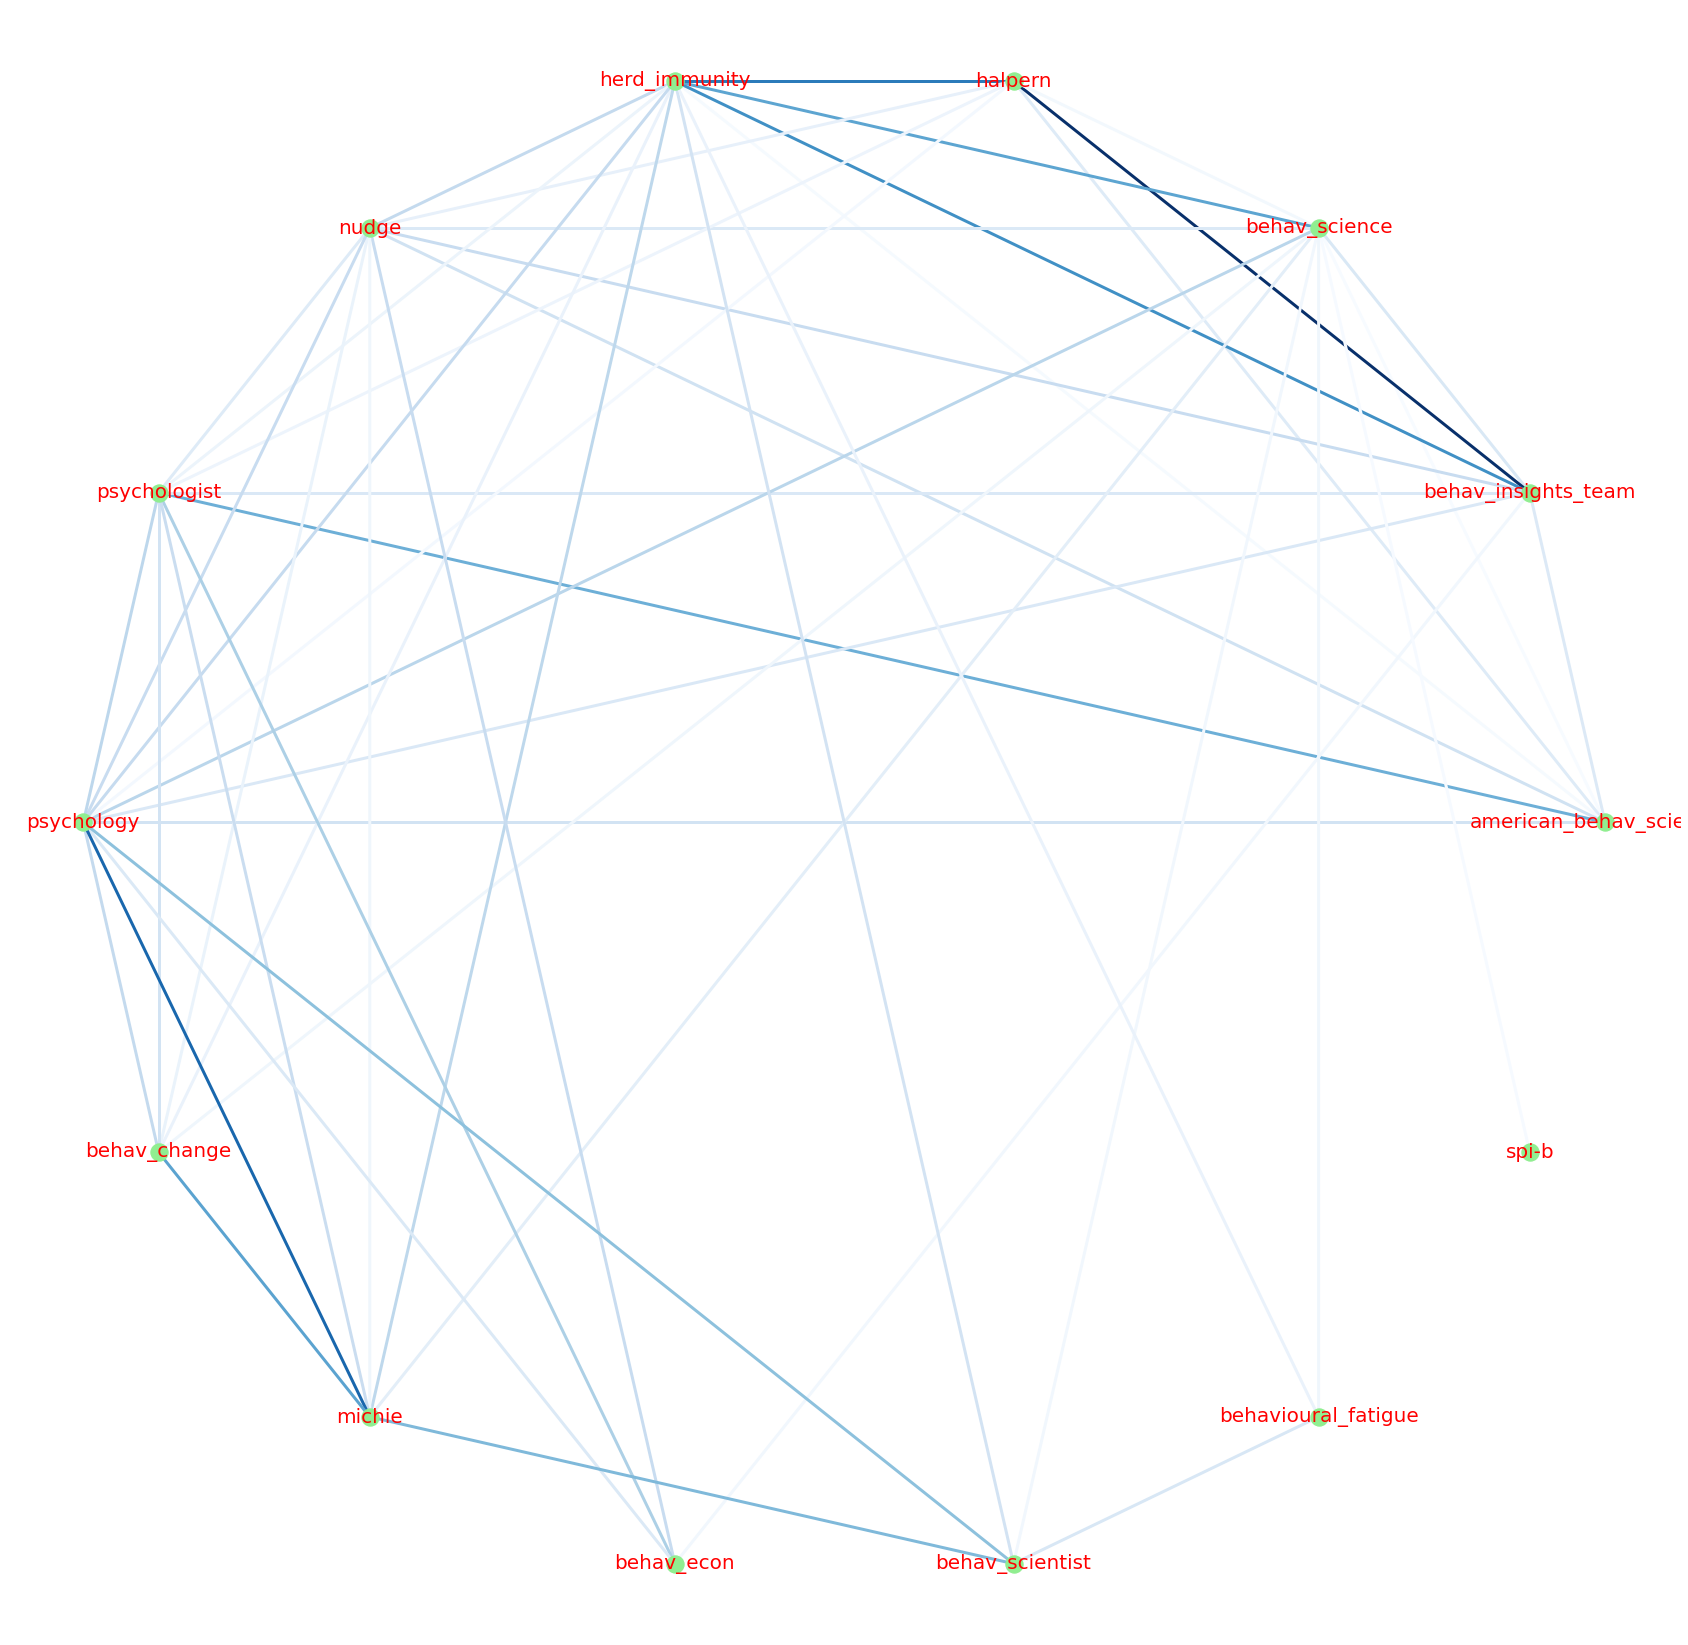

In [82]:
fig, ax = plt.subplots(figsize=(30,30))   
nx.draw_circular(before_dice_graph, 
                 with_labels=True, 
                 edge_color=before_dice_graph_weights,
                 width=3,
                 node_color='lightgreen',
                 font_size=20,
                 font_color='red',
                 font_weight=3,
                 edge_cmap=plt.cm.Blues
                )

### During lockdown

In [83]:
# drop NaN cases and 0.0 values
lock_dice_coefs.dropna(inplace=True)

In [84]:
lock_dice_coefs = lock_dice_coefs[lock_dice_coefs.lock_weight > 0.0]

In [85]:
lock_dice_graph = nx.from_pandas_edgelist(lock_dice_coefs[['source', 'target', 'lock_weight']], edge_attr=True)

In [86]:
# take a look at one
print(nx.to_dict_of_dicts(lock_dice_graph).get('michie'))

{'behav_change': {'lock_weight': 0.5142857142857142}, 'behav_insights_team': {'lock_weight': 0.02631578947368421}, 'behav_science': {'lock_weight': 0.12359550561797752}, 'behav_scientist': {'lock_weight': 0.05}, 'halpern': {'lock_weight': 0.031746031746031744}, 'herd_immunity': {'lock_weight': 0.10869565217391304}, 'psychologist': {'lock_weight': 0.16216216216216217}, 'psychology': {'lock_weight': 0.24242424242424243}, 'spi-b': {'lock_weight': 0.07407407407407407}}


In [87]:
# extract weights, we'll use them for plotting
lock_dice_weights = list(nx.get_edge_attributes(lock_dice_graph,'lock_weight').values())

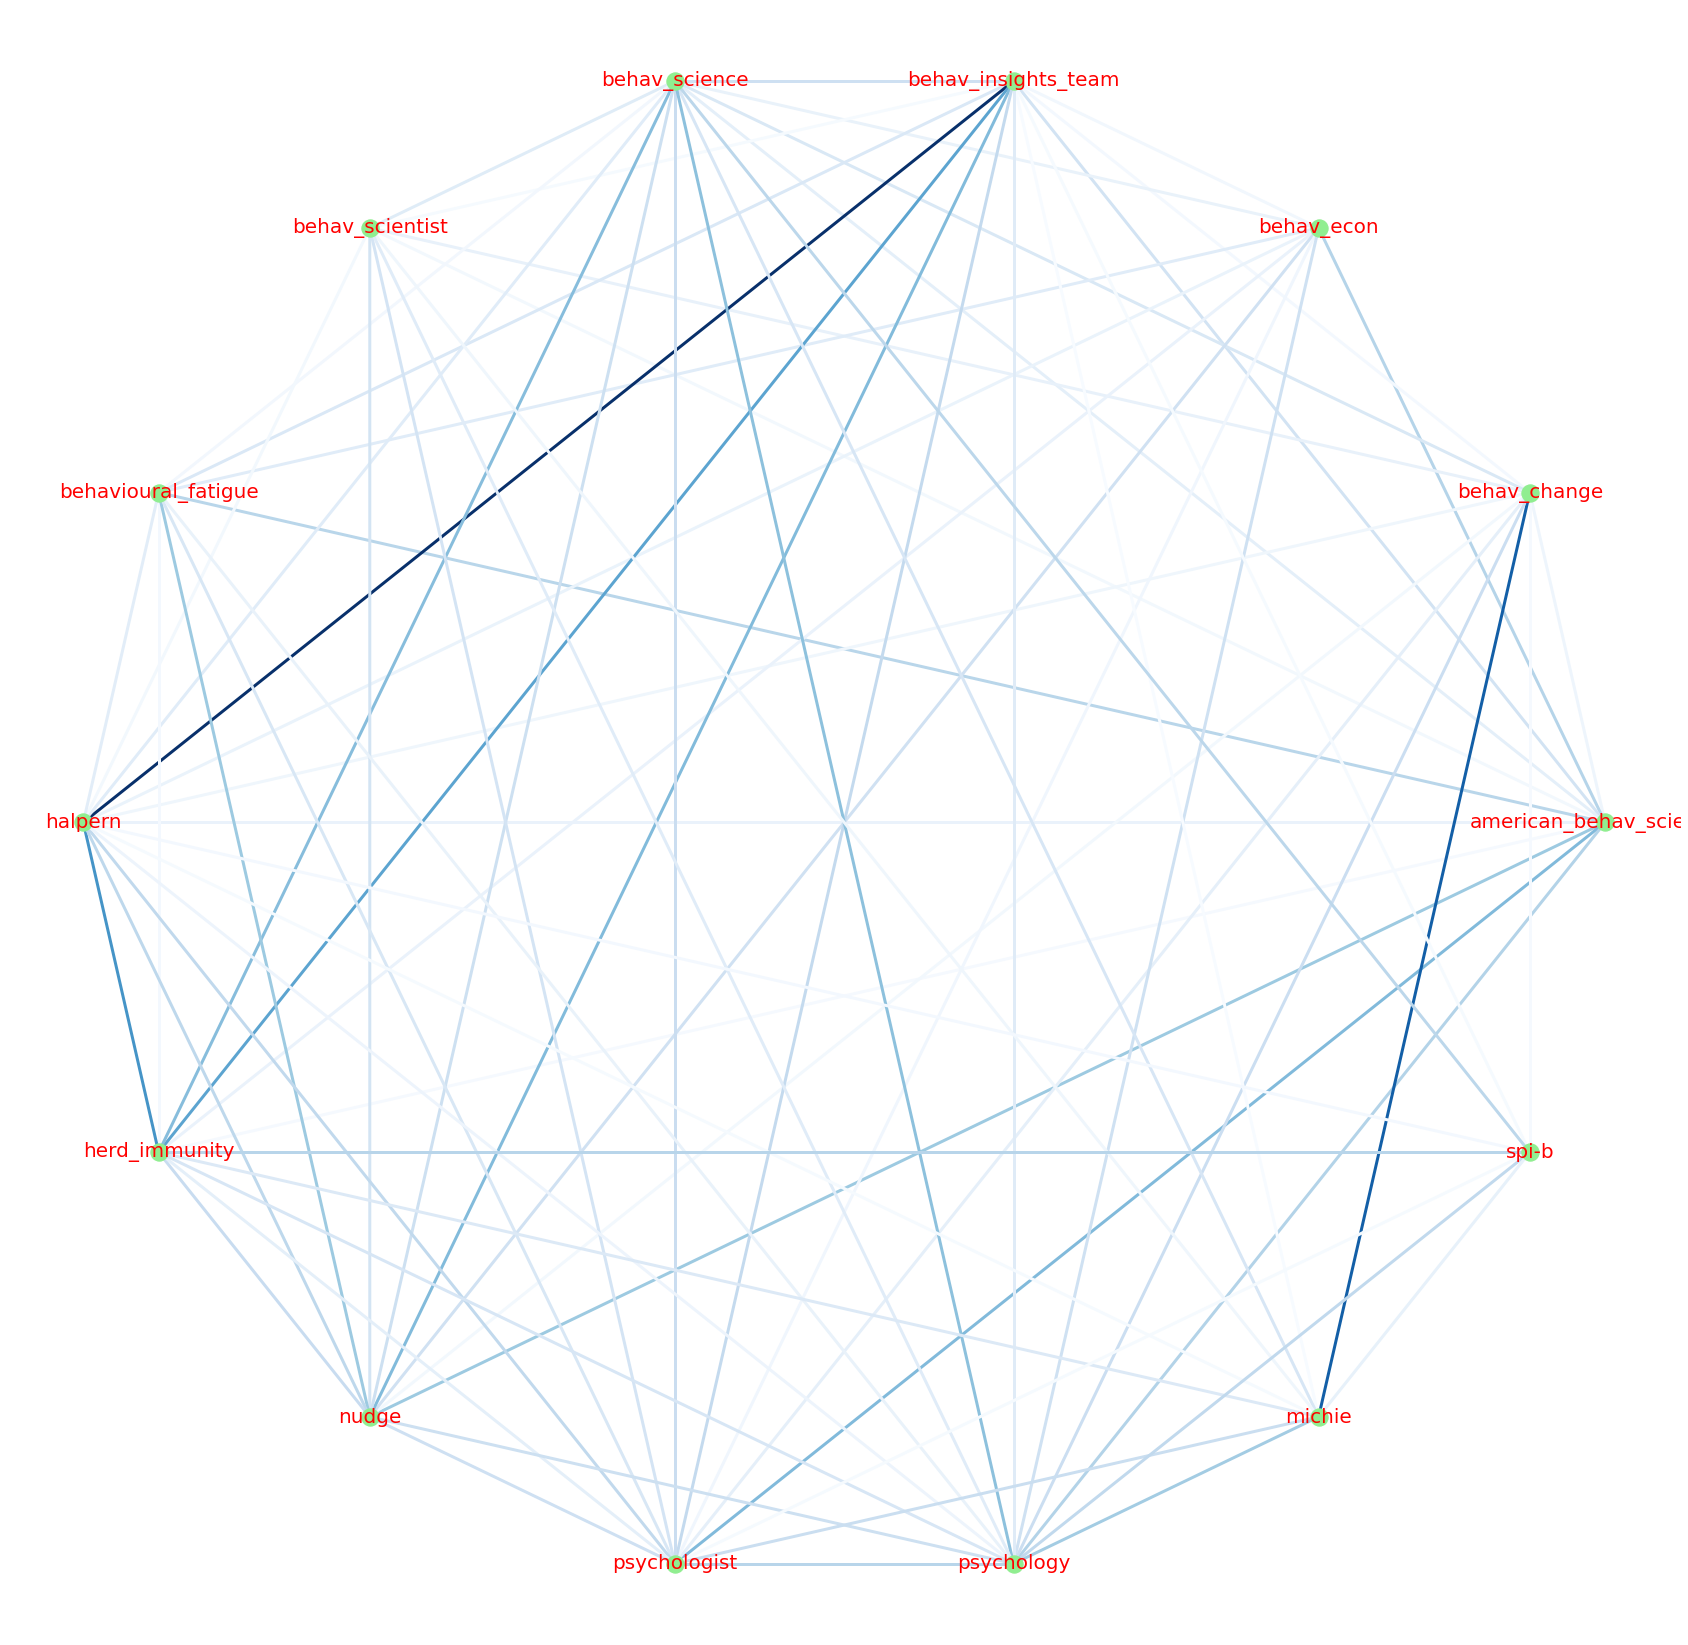

In [88]:
fig, ax = plt.subplots(figsize=(30,30))   
nx.draw_circular(lock_dice_graph, 
                 with_labels=True, 
                 edge_color=lock_dice_weights,
                 width=3,
                 node_color='lightgreen',
                 font_size=20,
                 font_color='red',
                 font_weight=3,
                 edge_cmap=plt.cm.Blues
                )

## After strict lockdown

In [89]:
post_dice_coefs.dropna(inplace=True)

In [90]:
post_dice_coefs = post_dice_coefs[post_dice_coefs.post_weight > 0.0]

In [91]:
post_dice_graph = nx.from_pandas_edgelist(post_dice_coefs[['source', 'target', 'post_weight']], edge_attr=True)

In [92]:
# take a look at one
print(nx.to_dict_of_dicts(post_dice_graph).get('michie'))

{'behav_change': {'post_weight': 0.46875}, 'behav_science': {'post_weight': 0.21686746987951808}, 'behav_scientist': {'post_weight': 0.14285714285714285}, 'herd_immunity': {'post_weight': 0.08955223880597014}, 'psychologist': {'post_weight': 0.24}, 'psychology': {'post_weight': 0.3516483516483517}, 'spi-b': {'post_weight': 0.1702127659574468}}


In [93]:
# extract weights, we'll use them for plotting
post_dice_weights = list(nx.get_edge_attributes(post_dice_graph,'post_weight').values())

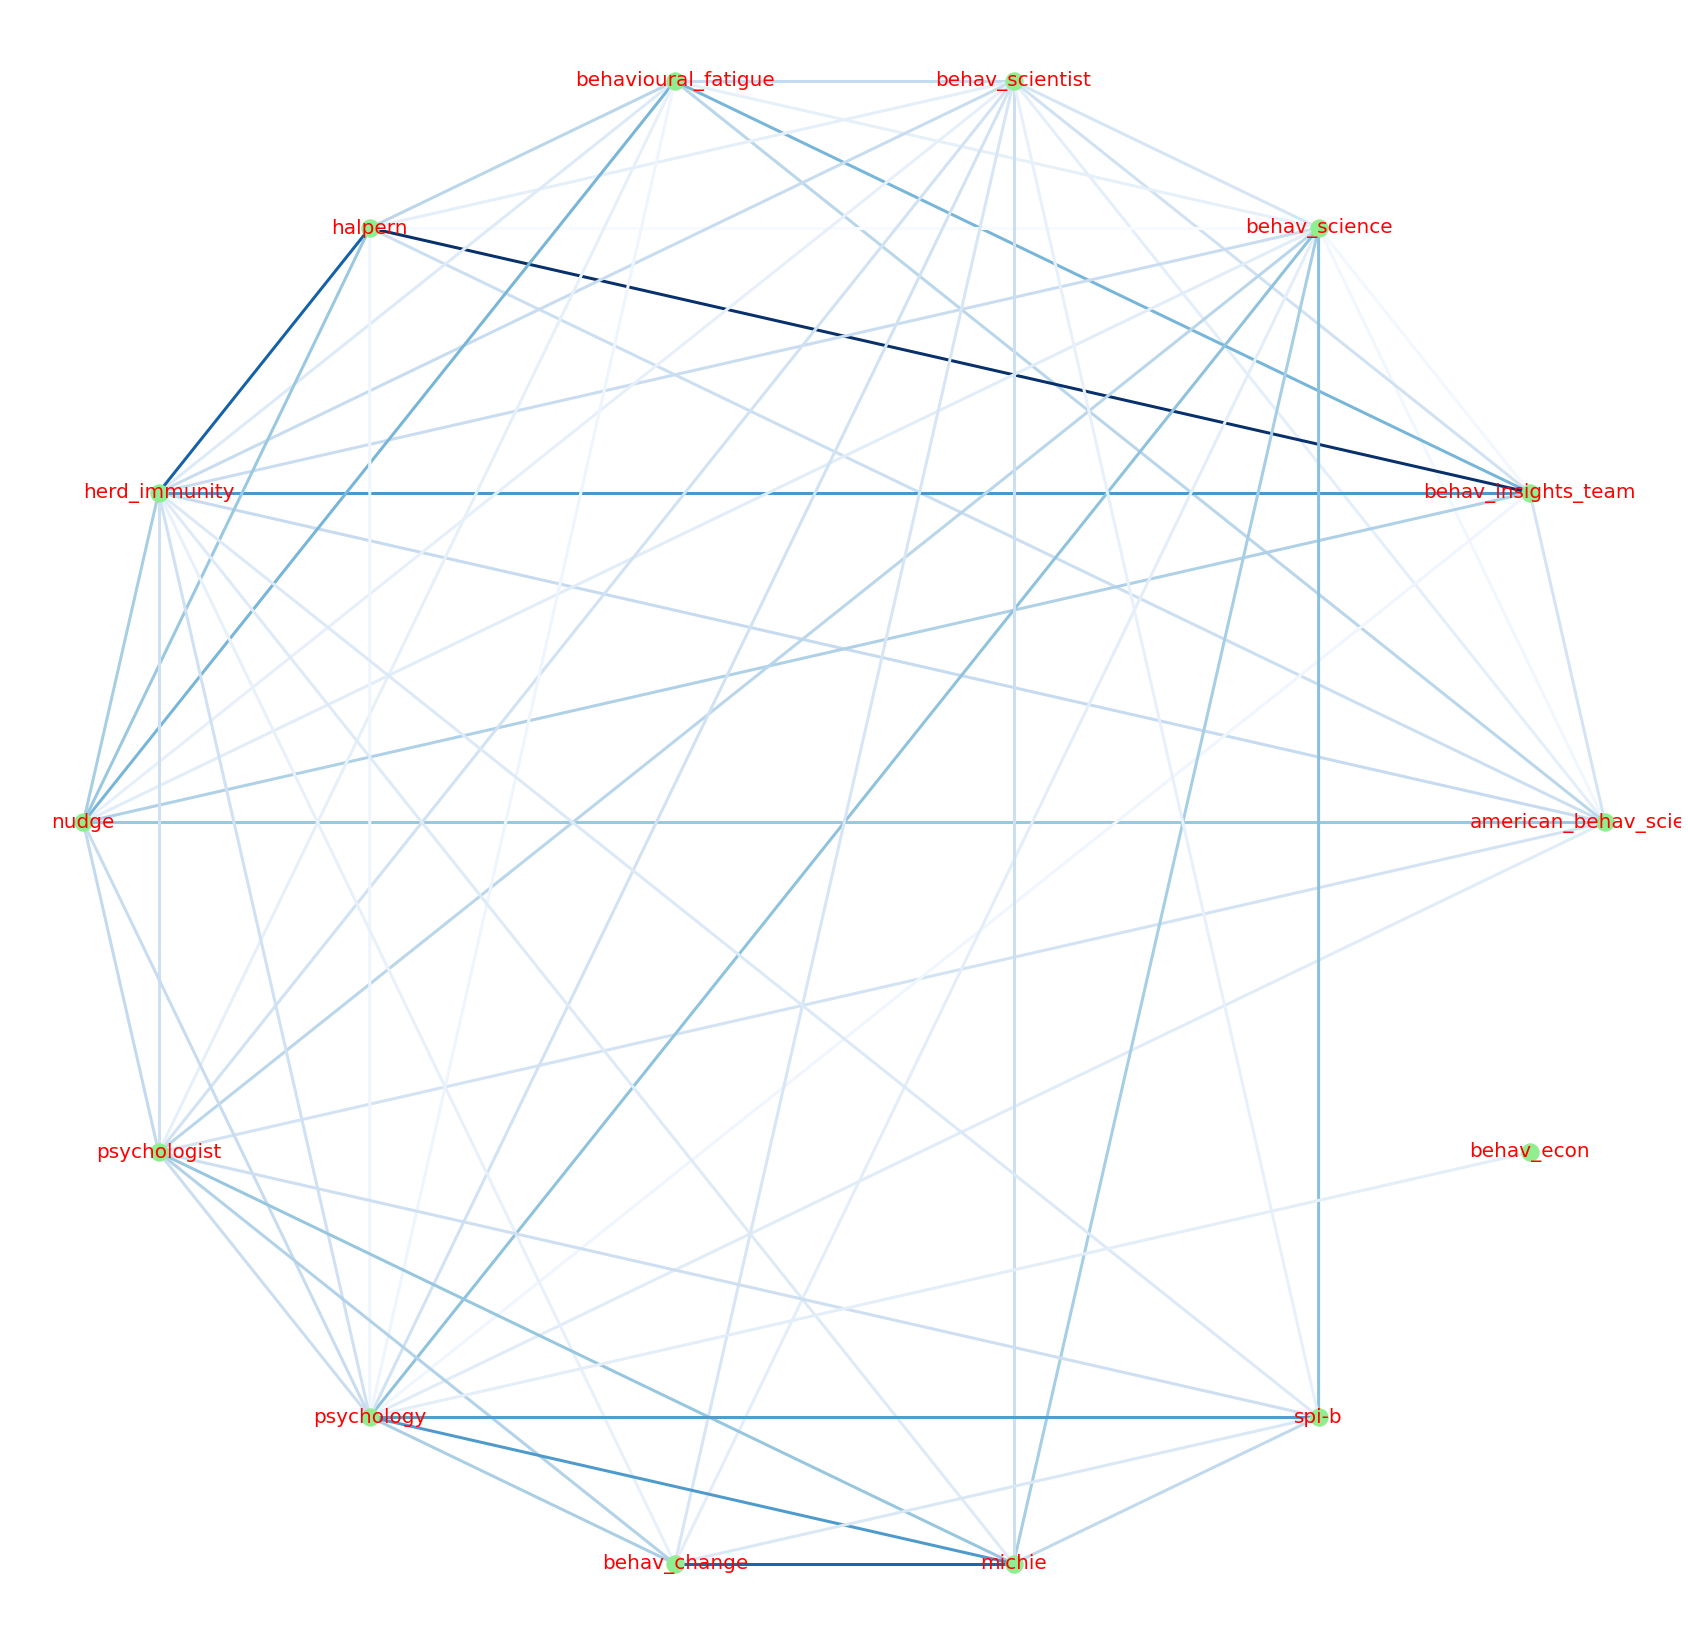

In [94]:
fig, ax = plt.subplots(figsize=(30,30))   
nx.draw_circular(post_dice_graph, 
                 with_labels=True, 
                 edge_color=post_dice_weights,
                 width=3,
                 node_color='lightgreen',
                 font_size=20,
                 font_color='red',
                 font_weight=3,
                 edge_cmap=plt.cm.Blues
                )

In [95]:
post_dice_coefs

,source,target,post_weight,post_co-occ,post_source_docfreq,post_target_docfreq
2,american_behav_scientists,behav_insights_team,0.117647,1,7,10
3,american_behav_scientists,behav_science,0.032258,2,7,117
4,american_behav_scientists,behav_scientist,0.071429,1,7,21
5,american_behav_scientists,behavioural_fatigue,0.181818,1,7,4
6,american_behav_scientists,halpern,0.142857,1,7,7
...,...,...,...,...,...,...
85,nudge,psychologist,0.166667,3,10,26
86,nudge,psychology,0.153846,4,10,42
88,psychologist,psychology,0.147059,5,26,42
89,psychologist,spi-b,0.140845,5,26,45


## Characteristics of the three networks and nodes

Main ref: https://programminghistorian.org/en/lessons/exploring-and-analyzing-network-data-with-python

### Number of nodes (keywords that co-occured)

In [99]:
print("Number of keywords co-occurring before-lockdown:", len(before_dice_graph.nodes))

Number of keywords co-occurring before-lockdown: 14


In [100]:
print("Number of keywords co-occurring during-lockdown:", len(lock_dice_graph.nodes))

Number of keywords co-occurring during-lockdown: 14


In [101]:
print("Number of keywords co-occurring post-lockdown:", len(post_dice_graph.nodes))

Number of keywords co-occurring post-lockdown: 14


### Network density

Network density
= ratio between actual number of connections between nodes and maximum possible number of connections.

Give a sense of how closely knit the network is, a higher value (within [0,1]) indicates a more cohesive network, so a set of keywords that do tend to co-occur.



In [102]:
before_density = nx.density(before_dice_graph)
print("Network density (before lockdown):", before_density)

Network density (before lockdown): 0.5494505494505495


In [103]:
lock_density = nx.density(lock_dice_graph)
print("Network density (during lockdown):", lock_density)

Network density (during lockdown): 0.8351648351648352


In [105]:
post_density = nx.density(post_dice_graph)
print("Network density (post lockdown):", post_density)

Network density (post lockdown): 0.6813186813186813


- Network density has increased during lockdown compared to pre-lockdown. 
    Interpretation: an increase in the general tendency of keywords to co-occur together in the same documents. 
    
- Network density decreased post lockdown compared to lockdown but remained higher than during pre-lockdown period.

### Network Clustering Coefficient

= n^ of connections between the neighbour nodes of a node / maximum possible number of connections between its neighbour nodes

(neighbour nodes are the nodes directly connected to a node).

A measure of the degree to which nodes in a graph tend to cluster together.

In [106]:
before_clustcoef = nx.average_clustering(before_dice_graph, weight='bef_weights')
print("Network clustering coefficient (before lockdown):", before_clustcoef)

Network clustering coefficient (before lockdown): 0.74428983714698


In [107]:
lock_clustcoef = nx.average_clustering(lock_dice_graph, weight='lock_weights')
print("Network clustering coefficient (during lockdown):", lock_clustcoef)

Network clustering coefficient (during lockdown): 0.8849364920793492


In [108]:
post_clustcoef = nx.average_clustering(post_dice_graph, weight='lock_weights')
print("Network clustering coefficient (during lockdown):", post_clustcoef)

Network clustering coefficient (during lockdown): 0.8206293706293707


Increased during lockdown and remained higher than pre-lockdown also in the post-lockdown period. 

## Centrality measures

Identify nodes (keywords) that are more important in the networks and compare the ranking them over time.

### Node Degree

The number of connection a node has. 

Here is with how many different keywords does each keyword co-occur?
Note that this is likely to be proportional to the keyword's frequency. Something we can also report.

In [109]:
def get_node_degree(graph):
    node_degree_dict = {}
    for node in graph.nodes:
        node_degree_dict[node] = nx.degree(graph, node)
    return node_degree_dict    

Before lockdown

In [110]:
before_node_degrees = pd.Series(get_node_degree(before_dice_graph)).sort_values(ascending=False)
print(before_node_degrees)

psychology                   11
herd_immunity                11
behav_science                11
nudge                        10
psychologist                  9
behav_insights_team           8
michie                        7
halpern                       7
american_behav_scientists     7
behav_change                  6
behav_scientist               5
behav_econ                    4
behavioural_fatigue           3
spi-b                         1
dtype: int64


During lockdown

In [111]:
lock_node_degrees = pd.Series(get_node_degree(lock_dice_graph)).sort_values(ascending=False)
print(lock_node_degrees)

psychology                   13
psychologist                 13
halpern                      13
behav_science                13
behav_insights_team          13
nudge                        11
herd_immunity                11
american_behav_scientists    11
behav_change                 10
michie                        9
behavioural_fatigue           9
behav_scientist               9
behav_econ                    9
spi-b                         8
dtype: int64


Post lockdown

In [112]:
post_node_degrees = pd.Series(get_node_degree(post_dice_graph)).sort_values(ascending=False)
print(post_node_degrees)

psychology                   13
herd_immunity                12
behav_scientist              12
behav_science                12
psychologist                 10
nudge                         9
behavioural_fatigue           9
american_behav_scientists     9
halpern                       8
behav_insights_team           8
spi-b                         7
michie                        7
behav_change                  7
behav_econ                    1
dtype: int64


In [ ]:
# alternative way to calculate it

In [113]:
before_degree_dict = dict(before_dice_graph.degree(before_dice_graph.nodes()))
nx.set_node_attributes(before_dice_graph, before_degree_dict, 'degree')

In [114]:
lock_degree_dict = dict(lock_dice_graph.degree(lock_dice_graph.nodes()))
nx.set_node_attributes(lock_dice_graph, lock_degree_dict, 'degree')

In [122]:
post_degree_dict = dict(post_dice_graph.degree(post_dice_graph.nodes()))
nx.set_node_attributes(post_dice_graph, post_degree_dict, 'degree')

### Node Betweeness Centrality

Betweenness centrality doesn’t care about the number of edges any one node or set of nodes has. Betweenness centrality looks at all the shortest paths that pass through a particular node.

So a keyword with a high betweeness centrality is a keyword that works as a bridge by connecting several different other keywords - i.e., it is discussed in articles with a wider variety of other keywords.

#### Pre-lockdown

In [115]:
before_betweenness_dict = nx.betweenness_centrality(before_dice_graph) 

# Assign each to an attribute in your network
nx.set_node_attributes(before_dice_graph, before_betweenness_dict, 'betweenness')


In [116]:
sorted(before_betweenness_dict.items(), key=itemgetter(1), reverse=True)

[('behav_science', 0.23386752136752137),
 ('herd_immunity', 0.1019230769230769),
 ('psychology', 0.08643162393162393),
 ('nudge', 0.0485042735042735),
 ('psychologist', 0.03514957264957266),
 ('behav_insights_team', 0.024572649572649572),
 ('michie', 0.013888888888888888),
 ('behav_scientist', 0.010149572649572648),
 ('american_behav_scientists', 0.003205128205128205),
 ('halpern', 0.003205128205128205),
 ('behav_change', 0.003205128205128205),
 ('behav_econ', 0.0),
 ('behavioural_fatigue', 0.0),
 ('spi-b', 0.0)]

Compare degree and between centrality

In [117]:
#Then find and print their degree
for tb in sorted(before_betweenness_dict.items(), key=itemgetter(1), reverse=True): 
    degree = before_degree_dict[tb[0]] # Use degree_dict to access a node's degree
    print("Name:", tb[0], "| Betweenness Centrality:", tb[1], "| Degree:", degree)

Name: behav_science | Betweenness Centrality: 0.23386752136752137 | Degree: 11
Name: herd_immunity | Betweenness Centrality: 0.1019230769230769 | Degree: 11
Name: psychology | Betweenness Centrality: 0.08643162393162393 | Degree: 11
Name: nudge | Betweenness Centrality: 0.0485042735042735 | Degree: 10
Name: psychologist | Betweenness Centrality: 0.03514957264957266 | Degree: 9
Name: behav_insights_team | Betweenness Centrality: 0.024572649572649572 | Degree: 8
Name: michie | Betweenness Centrality: 0.013888888888888888 | Degree: 7
Name: behav_scientist | Betweenness Centrality: 0.010149572649572648 | Degree: 5
Name: american_behav_scientists | Betweenness Centrality: 0.003205128205128205 | Degree: 7
Name: halpern | Betweenness Centrality: 0.003205128205128205 | Degree: 7
Name: behav_change | Betweenness Centrality: 0.003205128205128205 | Degree: 6
Name: behav_econ | Betweenness Centrality: 0.0 | Degree: 4
Name: behavioural_fatigue | Betweenness Centrality: 0.0 | Degree: 3
Name: spi-b |

#### During lockdown

In [118]:
lock_betweenness_dict = nx.betweenness_centrality(lock_dice_graph) 

# Assign each to an attribute in your network
nx.set_node_attributes(lock_dice_graph, lock_betweenness_dict, 'betweenness')


sorted(lock_betweenness_dict.items(), key=itemgetter(1), reverse=True)

[('behav_insights_team', 0.027599715099715098),
 ('behav_science', 0.027599715099715098),
 ('halpern', 0.027599715099715098),
 ('psychologist', 0.027599715099715098),
 ('psychology', 0.027599715099715098),
 ('herd_immunity', 0.015415140415140414),
 ('american_behav_scientists', 0.010353072853072853),
 ('nudge', 0.010353072853072853),
 ('behav_change', 0.0086996336996337),
 ('michie', 0.004858567358567358),
 ('behav_scientist', 0.003205128205128205),
 ('spi-b', 0.0014245014245014244),
 ('behav_econ', 0.0),
 ('behavioural_fatigue', 0.0)]

Compare degree and between centrality

In [119]:
for tb in sorted(lock_betweenness_dict.items(), key=itemgetter(1), reverse=True): 
    degree = lock_degree_dict[tb[0]] # Use degree_dict to access a node's degree
    print("Name:", tb[0], "| Betweenness Centrality:", tb[1], "| Degree:", degree)

Name: behav_insights_team | Betweenness Centrality: 0.027599715099715098 | Degree: 13
Name: behav_science | Betweenness Centrality: 0.027599715099715098 | Degree: 13
Name: halpern | Betweenness Centrality: 0.027599715099715098 | Degree: 13
Name: psychologist | Betweenness Centrality: 0.027599715099715098 | Degree: 13
Name: psychology | Betweenness Centrality: 0.027599715099715098 | Degree: 13
Name: herd_immunity | Betweenness Centrality: 0.015415140415140414 | Degree: 11
Name: american_behav_scientists | Betweenness Centrality: 0.010353072853072853 | Degree: 11
Name: nudge | Betweenness Centrality: 0.010353072853072853 | Degree: 11
Name: behav_change | Betweenness Centrality: 0.0086996336996337 | Degree: 10
Name: michie | Betweenness Centrality: 0.004858567358567358 | Degree: 9
Name: behav_scientist | Betweenness Centrality: 0.003205128205128205 | Degree: 9
Name: spi-b | Betweenness Centrality: 0.0014245014245014244 | Degree: 8
Name: behav_econ | Betweenness Centrality: 0.0 | Degree: 9

#### Post lockdown

In [120]:
post_betweenness_dict = nx.betweenness_centrality(post_dice_graph) 

# Assign each to an attribute in your network
nx.set_node_attributes(post_dice_graph, post_betweenness_dict, 'betweenness')


sorted(post_betweenness_dict.items(), key=itemgetter(1), reverse=True)

[('psychology', 0.1998168498168498),
 ('behav_science', 0.04597069597069597),
 ('behav_scientist', 0.04597069597069597),
 ('herd_immunity', 0.04597069597069597),
 ('psychologist', 0.023076923076923078),
 ('american_behav_scientists', 0.0036630036630036626),
 ('behavioural_fatigue', 0.0036630036630036626),
 ('nudge', 0.0036630036630036626),
 ('behav_insights_team', 0.0),
 ('halpern', 0.0),
 ('behav_change', 0.0),
 ('michie', 0.0),
 ('spi-b', 0.0),
 ('behav_econ', 0.0)]

In [123]:
for tb in sorted(post_betweenness_dict.items(), key=itemgetter(1), reverse=True): 
    degree = post_degree_dict[tb[0]] # Use degree_dict to access a node's degree
    print("Name:", tb[0], "| Betweenness Centrality:", tb[1], "| Degree:", degree)

Name: psychology | Betweenness Centrality: 0.1998168498168498 | Degree: 13
Name: behav_science | Betweenness Centrality: 0.04597069597069597 | Degree: 12
Name: behav_scientist | Betweenness Centrality: 0.04597069597069597 | Degree: 12
Name: herd_immunity | Betweenness Centrality: 0.04597069597069597 | Degree: 12
Name: psychologist | Betweenness Centrality: 0.023076923076923078 | Degree: 10
Name: american_behav_scientists | Betweenness Centrality: 0.0036630036630036626 | Degree: 9
Name: behavioural_fatigue | Betweenness Centrality: 0.0036630036630036626 | Degree: 9
Name: nudge | Betweenness Centrality: 0.0036630036630036626 | Degree: 9
Name: behav_insights_team | Betweenness Centrality: 0.0 | Degree: 8
Name: halpern | Betweenness Centrality: 0.0 | Degree: 8
Name: behav_change | Betweenness Centrality: 0.0 | Degree: 7
Name: michie | Betweenness Centrality: 0.0 | Degree: 7
Name: spi-b | Betweenness Centrality: 0.0 | Degree: 7
Name: behav_econ | Betweenness Centrality: 0.0 | Degree: 1
